In [2]:
import os 
import random
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.applications import VGG16
import tensorflow.keras.applications as app
from sklearn.metrics import confusion_matrix

In [3]:
imageSize=150
train_dir = "OCT2017/OCT2017/train/"
test_dir =  "OCT2017/OCT2017/test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
X = []
y = []

# there are four classes to be predicted
predictions = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
for i in range(0,4):
    # a counter is used to limit the number of images added to the training and testing dataset
    counter = 0;
    # iterating through the four directories and reading in images with the CV2 package
    for image in tqdm(os.listdir(train_dir + predictions[i])):
        img_file = cv2.imread(train_dir + predictions[i] + '/' + image)
        # only accepting valid images
        if img_file is not None:
            # resizing all image inputs to be at a standard (150, 150, 3) size
            img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
            img_arr = np.asarray(img_file)
            # adding image to the X matrix
            X.append(img_arr)
            # adding the index as the y target (0: normal, 1: cnv, 2: dme, 3: drusen)
            y.append(i)
        counter+=1
        if counter > 400:
            break

# converting to a numpy array
X_test = np.asarray(X)
y_test = np.asarray(y)


# split data into training and testing from the training directory 
# this design decision was made to minimize the amount of time needed to build a model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2)

  5%|▍         | 400/8616 [00:42<14:37,  9.36it/s]


In [4]:
# Scale images to the [0, 1] range
x_train = X_train.astype("float32") / 255
x_test = X_test.astype("float32") / 255

# Make sure images have shape (150, 150, 3)
print("x_train shape:", X_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to a hot vector: 0, 0, 0, 1 (like a binary output)
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

x_train shape: (1283, 150, 150, 3)
1283 train samples
321 test samples


In [28]:
# creating a sequential CNN using keras with maxpooling layers and dropout

model = keras.Sequential(
    [
        keras.Input(shape=(150, 150, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 41472)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [ ]:
# adding a list of metrics for the fit method to show
metrics_list = ['accuracy']
# compiling model with an optimizer and loss function
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics_list)
    # alternative: sparse_categorical_crossentropy

# fitting model to training set and using the testing set for validation
# TODO: change validation data to run on separate data
training = model.fit(x_train, y_train, batch_size=100, epochs=10, verbose=1, validation_split=0.1)

In [16]:
# evaluating the model on unseen testing data
score = model.evaluate(x_test, y_test, verbose=1)
# printing the loss and the accuracy of the model
print("Test loss:", score[0])
print("Test accuracy:", score[1])

321/321 [==============================] - 2s 5ms/sample - loss: 1.3518 - acc: 0.3925
Test loss: 1.3517967265714366
Test accuracy: 0.39252338


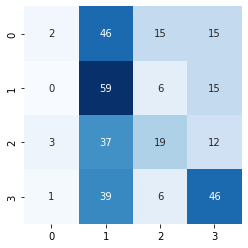

In [17]:
# visualizing the confusion matrix of the model
y_pred = model.predict(x_test)
y_pred_c = np.argmax(y_pred, axis=1)
y_test_c = np.argmax(y_test, axis=1)
matrix_confusion = confusion_matrix(y_test_c, y_pred_c)

sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False )
plt.show()

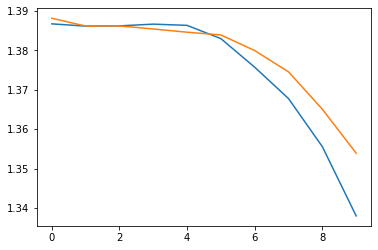

In [18]:
# visualizing the model loss over 10 epochs
x = list(range(10))
vy = training.history['val_loss']
ty = training.history['loss']

plt.plot( x, vy )
plt.plot( x, ty )
plt.show()